Building off my previous work on [Arlington Bikeometer data](https://georgetsilva.github.io/posts/exploring-arlingtons-bikeometer-data/) and [mapping points with Folium](https://georgetsilva.github.io/posts/mapping-points-with-folium/), I decided to contribute something to the upcoming [Walk Hack Night II](https://www.meetup.com/Transportation-Techies/events/236668724/). While I'm not able to attend this event, I still wanted to be able to add to the discussion with some data visualizations about local walking trends.<!-- TEASER_END -->

Many of the Eco-Counter installed on Arlington's trails can count both bicycle and pedestrian traffic. I decided to look through the various counter and find ones that had data for the past three years. My plan was then to calculate annual average daily traffic for the pedestrian traffic at each counter and then map the annualized growth rate for that metric for each location.

I used the following Python modules for this project.

In [1]:
import pandas as pd
import requests
from xml.etree import ElementTree

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import folium

Then I grabbed the counter ID numbers for the eleven stations that provided consistent data from January 1, 2014 to December 31, 2016.  Those counter IDs are listed below. When I browsed the data, I discovered some very large pedestrian counts that were obvious outliers.  Those outliers were probably the result of sensor errors. Upon further investigation, I noticed some of these outliers occurred during the evening hours, which should actually have pedestrian counts close to zero. Something strange seems to happen to these counters at night on occassion.

In [2]:
counterids = ['23', '3', '4', '27', '26', '7', '9', '11', '25', '12', '1']
pedestrian_growth = []

The code below fetches the daily pedestrian count data for each counter in the list above in an xml format. I dealt with outliers by dropping above the 95th percentile and the zeroes. I then summed the inbound and outbound pedestrian counts by day. I then calculated the average daily counts for the remaining data by month and then I calculated the yearly means based on those monthly averages.  Finally, I obtained the annualize rate of growth for the average annual daily pedestrian traffic numbers.  These statistics are reported below the following Python code.

Counter ID: #23
year
2014    265.0
2015    264.0
2016    269.0
Name: count, dtype: float64
23: 0.7% annualize growth rate
------------------------
Counter ID: #3
year
2014    408.0
2015    436.0
2016    430.0
Name: count, dtype: float64
3: 2.62% annualize growth rate
------------------------
Counter ID: #4
year
2014    351.0
2015    366.0
2016    418.0
Name: count, dtype: float64
4: 9.05% annualize growth rate
------------------------
Counter ID: #27
year
2014    61.0
2015    57.0
2016    64.0
Name: count, dtype: float64
27: 2.43% annualize growth rate
------------------------
Counter ID: #26
year
2014    92.0
2015    80.0
2016    90.0
Name: count, dtype: float64
26: -1.1% annualize growth rate
------------------------
Counter ID: #7
year
2014    932.0
2015    962.0
2016    958.0
Name: count, dtype: float64
7: 1.42% annualize growth rate
------------------------
Counter ID: #9
year
2014    397.0
2015    428.0
2016    308.0
Name: count, dtype: float64
9: -11.89% annualize growth rate
--

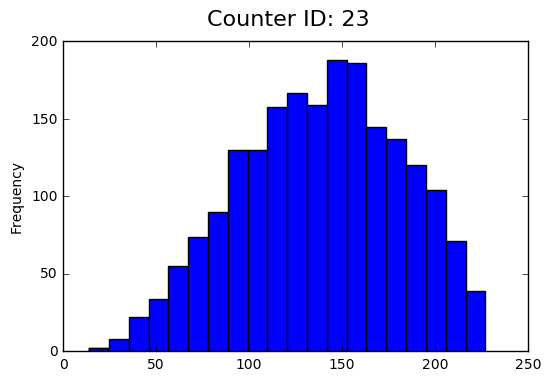

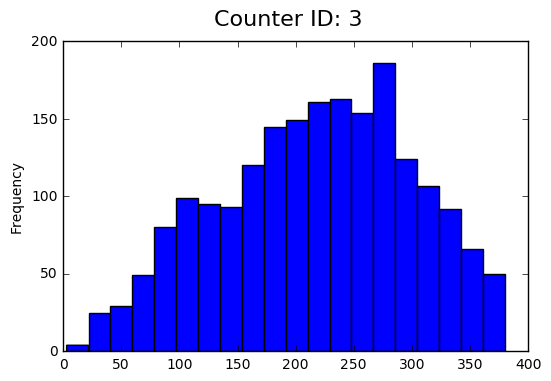

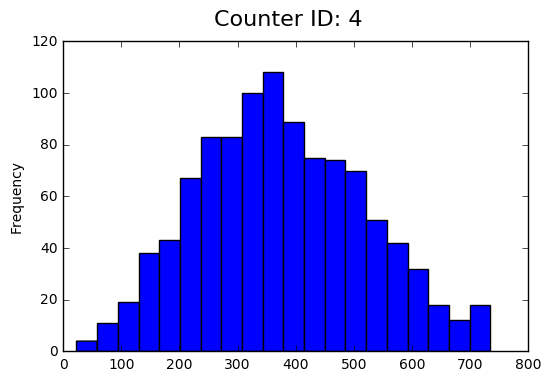

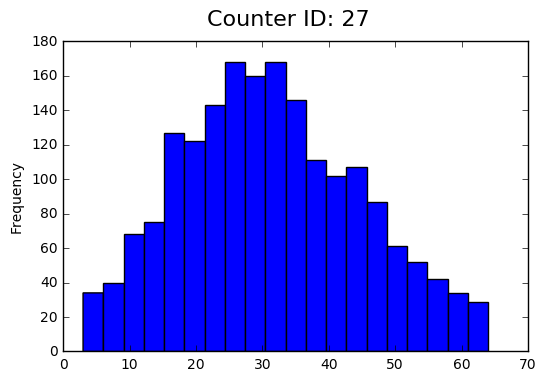

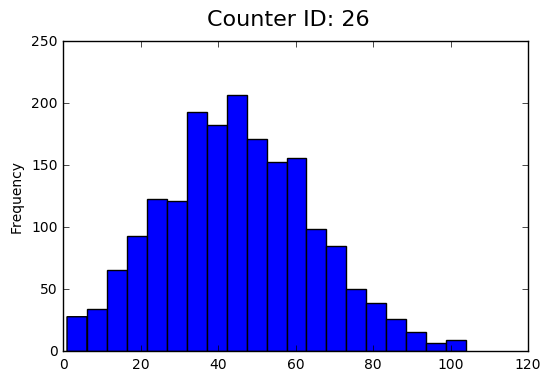

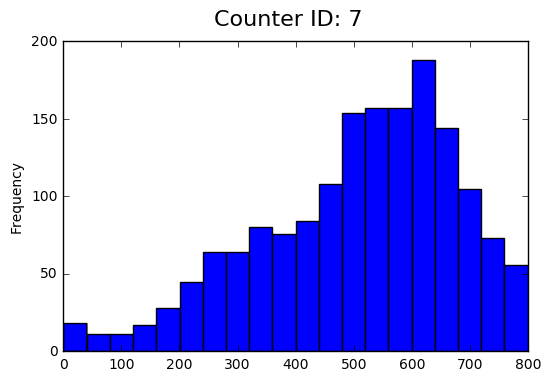

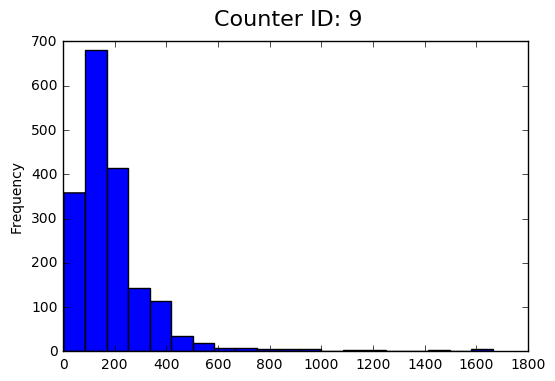

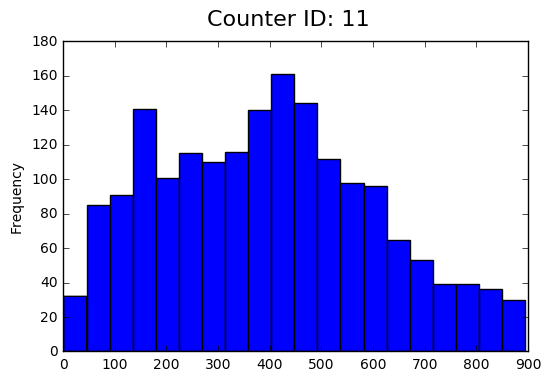

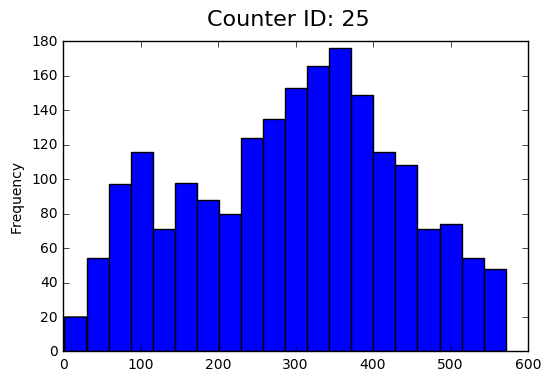

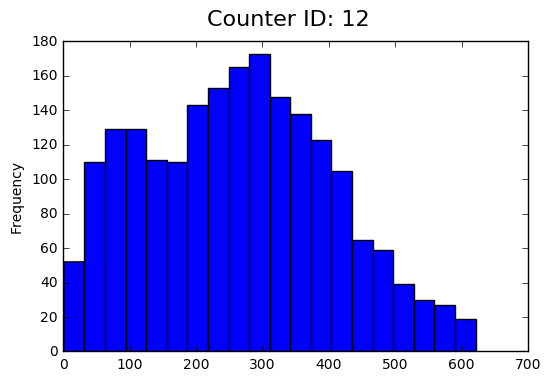

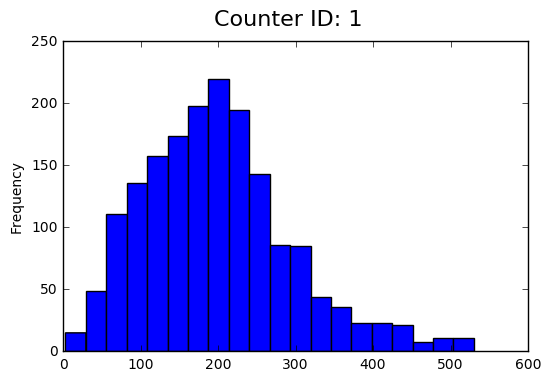

In [3]:
for cid in counterids:
    GetCountURL = ('http://webservices.commuterpage.com/counters.cfc?wsdl&method=GetCountInDateRange&startDate=1/1/2014&endDate=12/31/2016&direction=&mode=P&interval=d&counterid='
                  + cid)
    xmldata = requests.get(GetCountURL)
    tree = ElementTree.fromstring(xmldata.text)
    date = []
    count = []
    direction = []
    dfpeds = pd.DataFrame()
    for t in tree.findall('count'):
        date.append(t.attrib['date'])
        count.append(t.attrib['count'])
        direction.append(t.attrib['direction'])
    dfpeds = pd.DataFrame({'date' : date, 'count': count, 'direction': direction})
    dfpeds['date'] = pd.to_datetime(dfpeds.date)
    dfpeds['count'] = dfpeds['count'].astype(int)
    cleaned = dfpeds['count'] <= dfpeds['count'].quantile(0.95)
    zeroes = dfpeds['count'] != 0
    dfcleaned = dfpeds[cleaned & zeroes]
    fig = plt.figure()
    fig.suptitle('Counter ID: ' + cid, fontsize=16)
    dfcleaned['count'].plot(kind = 'hist', bins=20)
    df_bydate = dfcleaned.groupby('date').sum()
    df_bydate['Date'] = df_bydate.index
    df_bydate['month'] = df_bydate['Date'].dt.month
    df_bydate['year'] = df_bydate['Date'].dt.year
    bymonth = df_bydate.groupby(['year', 'month']).mean()
    byyear = bymonth['count'].mean(level='year')
    percent_change = ((byyear.iloc[2] / byyear.iloc[0]) ** (1/2) - 1) * 100
    pedestrian_growth.append(round(percent_change,2))
    textid = cid + ": " + str(round(percent_change,2)) + "% annualize growth rate"
    print('Counter ID: #' + cid)
    print(round(byyear, 0))
    print(textid)
    print('------------------------')

In [4]:
df_counterstats = pd.DataFrame({'Growth Rate': pedestrian_growth}, index=counterids)
df_counterstats

,Growth Rate
23,0.70
3,2.62
4,9.05
27,2.43
26,-1.10
7,1.42
9,-11.89
11,0.91
25,14.37
12,-5.07


Using the above DataFrame, I fetched the counter names and locations with the following code.

In [5]:
GetAllCountersUrl = "http://webservices.commuterpage.com/counters.cfc?wsdl&method=GetAllCounters"

xmlfile = open('xml_getallcounters.xml', 'w')
xmldata = requests.get(GetAllCountersUrl)
xmlfile.write(xmldata.text)
xmlfile.close()

xml_data = 'xml_getallcounters.xml'

tree = ElementTree.parse(xml_data)

In [6]:
id = []
name = []
latitude = []
longitude = []
region = []


for c in tree.findall('counter'):
    id.append(c.attrib['id'])
    name.append(c.find('name').text)
    latitude.append(c.find('latitude').text)
    longitude.append(c.find('longitude').text)
    region.append(c.find('region/name').text)

df_counters = pd.DataFrame(
    {'Name' : name,
     'latitude' : latitude,
     'longitude' : longitude,
     'region' : region
    }, index = id)
df_counters.head()

,Name,latitude,longitude,region
33,110 Trail,38.885315,-77.065022,Arlington
30,14th Street Bridge,38.874260,-77.044610,Arlington
43,15th Street NW,38.907470,-77.034610,DC
32,Arlington Mill Trail,38.845610,-77.096046,Arlington
24,Ballston Connector,38.882950,-77.121235,Arlington


In [7]:
df_growth_points = pd.concat([df_counters, df_counterstats], axis=1, join='inner')
df_growth_points['radius'] = (df_growth_points['Growth Rate'] * 5) + 120

def markercolors(counter):
    if counter['Growth Rate'] < -5:
        return 'DarkRed'
    elif counter['Growth Rate'] < -1:
        return 'Red'
    elif counter['Growth Rate'] < 1:
        return 'Yellow'
    elif counter['Growth Rate'] < 5:
        return 'Green'
    else:
        return 'DarkGreen'
df_growth_points["color"] = df_growth_points.apply(markercolors, axis=1)

df_growth_points

,Name,latitude,longitude,region,Growth Rate,radius,color
23,Bluemont Connector,38.880476,-77.119311,Arlington,0.70,123.50,Yellow
3,Custis Bon Air Park,38.879199,-77.138420,Arlington,2.62,133.10,Green
4,Custis Rosslyn,38.897191,-77.083031,Arlington,9.05,165.25,DarkGreen
27,Joyce St NB,38.867264,-77.062829,Arlington,2.43,132.15,Green
26,Joyce St SB,38.867271,-77.063054,Arlington,-1.10,114.50,Red
7,Key Bridge West,38.900539,-77.070900,Arlington,1.42,127.10,Green
9,MVT Airport South,38.844471,-77.048923,Arlington,-11.89,60.55,DarkRed
11,TR Island Bridge,38.897960,-77.067721,Arlington,0.91,124.55,Yellow
25,W&OD Bon Air West,38.879330,-77.139250,Arlington,14.37,191.85,DarkGreen
12,W&OD Columbia Pike,38.857085,-77.110789,Arlington,-5.07,94.65,DarkRed


In the data table above, you'll notice I also added a radius and color.  These are based on the annual daily pedestrian growth rates.  I need these attributes to create a point map that displays points of varying size and color based on the pedestrian growth rates. The large green circle indicate increases in the average annual number of walkers since 2014 and the small dark red circles indicate the largest declines in the number of daily pedestrians since 2014.

In [8]:
locations = df_growth_points[['latitude', 'longitude']]
locationlist = locations.values.tolist()

In [9]:
map = folium.Map(location=[38.87, -77.1], tiles='CartoDB positron', zoom_start=13)
folium.Icon()
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point], radius=df_growth_points['radius'][point], popup=df_growth_points['Name'][point]+': '+str(df_growth_points['Growth Rate'][point])+'%',
                        color=df_growth_points['color'][point], fill_color=df_growth_points['color'][point]).add_to(map)
map

You can click on each circle above to get the location name and the growth rate for that point.  My quick take is that there has been an increase in walkers on the Custis Trail.  Over the same time period the Columbia Pike and Mount Vernon points indicate decreases in pedestrian traffic counts. Planners may want to really focus on the conditions at the MVT Airport South counter to see if there needs to be any improvements for pedestrians in that area.

Please share your thoughts and ideas in the comment section below.